# Tutorial

Demonstração da utilização dos <a href="https://transparencia.sns.gov.pt/explore/?sort=title">dados disponibilizados</a> pelo <a href="https://www.sns.gov.pt/">Serviço Nacional de Saúde</a>.

O objectivo deste notebook é:

* Mostrar como obter dados utilizando a <a href="https://transparencia.sns.gov.pt/api/v1/console/datasets/1.0/search/">API</a> disponibilizada pela área de <a href="https://www.sns.gov.pt/transparencia/">Transparência do Portal do Serviço Nacional de Saúde</a>;
* Ilustrar o processo de limpeza e visualização destes dados;
* Explorar o impacto do  COVID-19 na sociedade em geral e em particular na prestação de cuidados de saúde em Portugal com questões como:
    * Como foi afectada a prestação de cuidados de oncologia?
    * Como foram afectadas as cirugias? 
    * Que impacto teve na mortalidade total em comparação com outros anos?
    * Qual o impacto da covid nas consultas médicas hospitalares e consultas em Telemedicina?
    * Como evoluiu a mobilidade dos portugueses com o aumento da fadiga pandémica? 
    * Qual o peso das condições meteorológicas na mobilidade?    
    * ...

## O que é uma API?

Os dados do portal estão disponíveis na internet para que qualquer pessoa possa encontrar, ver e descarregar os dados que pretende.

Uma API permite que um programa consiga facilmente efetuar as mesmas operações.

## Que operações estão disponíveis?

Existem neste momento duas versões da API cuja documentação pode ser consultada: a <a href="https://transparencia.sns.gov.pt/api/v1/console/datasets/1.0/search/">versão 1.0</a> e a <a href="https://transparencia.sns.gov.pt/api/v2/console">nova versão 2.0</a> que ainda está em desenvolvimento.

Ambas permitem procurar *datasets* conjuntos de dados sobre um tema específico, obter dados, procurar dados com características específicas e até efetuar algumas operações sobre os dados, por exemplo agrupá-los por ano, ou localização.

No âmbito deste tutorial, vamos utilizar a biblioteca **odsclient** que nos permite facilmente aceder aos dados do portal, **numpy** e **pandas** para manipular os dados, e para as visualizações vamos utilizar **seaborn** e **matplotlib**.

## Instalação de bibliotecas

A instalação das bibliotecas necessárias é muito simples:

Carregar as bibliotecas e algumas funções que vamos usar.

* `get_df_from_url` : descarrega um dataset que esteja disponível online como json
* `get_month_labels_from_date_columns`: cria labels como "Jan-2020" a partir de colunas do tipo datetime que vamos criar com os pivots mais abaixo.

In [1]:
%matplotlib inline

import requests
from calendar import month_abbr

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from odsclient import get_whole_dataframe
from matplotlib.ticker import MultipleLocator, FixedLocator


def get_df_from_url(url):
    response = requests.get(url)
    return pd.read_json(response.text)

def get_month_labels_from_date_columns(df):
    return [f"{month_abbr[dt.month]}-{dt.year}" for dt in df.columns]
    

# 1 - Consultas Médicas Hospitalares

Vamos olhar para os dados disponibilizados sobre <a href="https://transparencia.sns.gov.pt/explore/dataset/01_sica_evolucao-mensal-das-consultas-medicas-hospitalares">Consultas Médicas Hospitalares</a>


## 1.1 Obter os dados com odsclient

Na <a href="https://transparencia.sns.gov.pt/explore/dataset/01_sica_evolucao-mensal-das-consultas-medicas-hospitalares/api/?sort=periodo">tab API </a> do nosso dataset podemos encontrar o nome do dataset **01_sica_evolucao-mensal-das-consultas-medicas-hospitalares** e com ele podemos obter os dados prontos a tratar como um pandas dataframe:


In [2]:
df_hosp = get_whole_dataframe("01_sica_evolucao-mensal-das-consultas-medicas-hospitalares", 
                              base_url="https://transparencia.sns.gov.pt/", tqdm=True)
df_hosp.head()

https://transparencia.sns.gov.pt/explore/dataset/01_sica_evolucao-mensal-das-consultas-medicas-hospitalares/download/: 0.00B [00:04, ?B/s]


,Período,Periodo_format_2,Região,Instituição,Localização Geográfica,Nº Consultas Médicas Total,Nº Primeiras Consultas,Nº Consultas Subsequentes
0,2018-12,2018/12/01,Região de Saúde do Centro,"Centro Hospitalar de Leiria, EPE","39.7414812,-8.7982706",267101,86882,180219
1,2018-12,2018/12/01,Região de Saúde do Centro,"Centro Hospitalar do Baixo Vouga, EPE","40.6362453,-8.6543716",222249,63641,158608
2,2018-12,2018/12/01,Região de Saúde do Centro,"Unidade Local de Saúde de Castelo Branco, EPE","39.8212263,-7.4981271",84833,28507,56326
3,2018-12,2018/12/01,Região de Saúde LVT,"Centro Hospitalar do Oeste, EPE","39.4054629,-9.1258493",139138,44003,95135
4,2018-12,2018/12/01,Região de Saúde LVT,Centro Hospitalar Universitário de Lisboa Nort...,"38.7500861,-9.1616116",717338,181841,535497


## 1.2 Distribuição das instituições por  região

Para começar, quantas instituições existem e a que regiões pertencem?

,Instituição
Região,
Região de Saúde LVT,16
Região de Saúde Norte,18
Região de Saúde do Alentejo,4
Região de Saúde do Algarve,1
Região de Saúde do Centro,13


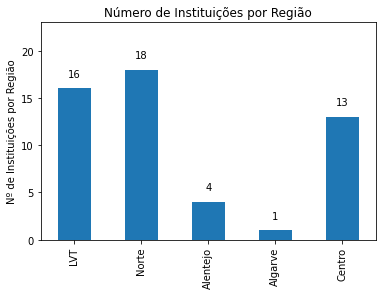

In [3]:
df_num_inst = df_hosp[['Região', 'Instituição']].groupby('Região').nunique()
display(df_num_inst)

ax = df_num_inst.plot(kind='bar')
ax.set_title('Número de Instituições por Região');
ax.set_ylabel('Nº de Instituições por Região');
ax.set_xlabel('');
ax.get_legend().remove()
ax.set_xticklabels([região.split()[-1] for região in df_num_inst.index], rotation=90);
ax.set_ylim(0,23)
bars = ax.patches

for bar, value in zip(bars, df_num_inst.Instituição.values):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 1, value, ha='center', va='bottom')


## 1.3 Distribuição das consultas por instituição

Para obter uma primeira ideia dos dados iremos analisar a variabilidade do número de consultas em cada instituição e região:

In [4]:
df_hosp.groupby(['Região','Instituição']).agg({'Período' : ['min', 'max', 'count'],
                                               'Nº Consultas Médicas Total':['sum', 'min', 'max', 'mean','std']})

Período  \
                                                                                    min   
Região                      Instituição                                                   
Região de Saúde LVT         Centro Hospitalar Barreiro/Montijo, EPE             2013-01   
                            Centro Hospitalar Médio Tejo, EPE                   2013-01   
                            Centro Hospitalar Psiquiátrico de Lisboa            2013-01   
                            Centro Hospitalar Universitário Lisboa Central,...  2013-01   
                            Centro Hospitalar Universitário de Lisboa Norte...  2013-01   
                            Centro Hospitalar de Lisboa Ocidental, EPE          2013-01   
                            Centro Hospitalar de Setúbal, EPE                   2013-01   
                            Centro Hospitalar do Oeste, EPE                     2013-01   
                            Hospital Distrital de Santarém, EPE                 2013-01   
                            Hospital Garcia de Orta, EPE                        2013-01   
                            Hospital Professor Doutor Fernando Fonseca, EPE     2013-01   
                            Hospital de Cascais, PPP                            2013-01   
                            Hospital de Loures, PPP                             2013-01   
                            Hospital de Vila Franca de Xira, PPP                2013-01   
                            Instituto Gama Pinto                                2013-01   
                            Instituto Português Oncologia de Lisboa, EPE        2013-01   
Região de Saúde Norte       Centro Hospitalar Entre Douro e Vouga, EPE          2013-01   
                            Centro Hospitalar Póvoa de Varzim/Vila do Conde...  2013-01   
                            Centro Hospitalar Trás-os-Montes e Alto Douro, EPE  2013-01   
                            Centro Hospitalar Tâmega e Sousa, EPE               2013-01   
                            Centro Hospitalar Universitário de São João, EPE    2013-01   
                            Centro Hospitalar Universitário do Porto, EPE       2013-01   
                            Centro Hospitalar Vila Nova de Gaia/Espinho, EPE    2013-01   
                            Centro Hospitalar do Alto Ave, EPE                  2013-01   
                            Centro Hospitalar do Médio Ave, EPE                 2013-01   
                            Hospital Santa Maria Maior, EPE                     2013-01   
                            Hospital da Senhora da Oliveira, Guimarães, EPE     2015-01   
                            Hospital de Braga, EPE                              2019-09   
                            Hospital de Braga, PPP                              2013-01   
                            Hospital de Magalhães Lemos, EPE                    2013-01   
                            Instituto Português Oncologia do Porto, EPE         2013-01   
                            Unidade Local de Saúde de Matosinhos, EPE           2013-01   
                            Unidade Local de Saúde do Alto Minho, EPE           2013-01   
                            Unidade Local de Saúde do Nordeste, EPE             2013-01   
Região de Saúde do Alentejo Hospital Espírito Santo de Évora, EPE               2013-01   
                            Unidade Local de Saúde do Baixo Alentejo, EPE       2013-01   
                            Unidade Local de Saúde do Litoral Alentejano, EPE   2013-01   
                            Unidade Local de Saúde do Norte Alentejano, EPE     2013-01   
Região de Saúde do Algarve  Centro Hospitalar Universitário do Algarve,EPE      2013-01   
Região de Saúde do Centro   Centro Hospitalar Tondela-Viseu, EPE                2013-01   
                            Centro Hospitalar Universitário Cova da Beira, EPE  2013-01   
                            Centro Hospitalar de Leiria, EPE                

Da análise desta tabela observamos:

* Os dados são entre Janeiro de 2013 e Março de 2021, mas nem todas as instituições têm todos os meses
* O número mínimo de consultas médicas é muito menor quer que a média
* O desvio padrão é muito maior que o valor mínimo
* Isto acontece de forma consistente para todas as instituições
* Focando num único hospital, por exemplo o IPO em Lisboa:
  * O IPO tem <a href="https://www.ipolisboa.min-saude.pt/ipo/conheca-nos/">360 médicos</a>
  * Nem todos os médicos do IPO trabalham em exclusividade, nem dão consultas todos os dias
  * Os médicos têm férias, outros deveres além das consultas e têm de ter algumas pausas durante o dia
  * O máximo mensal para o IPO em Lisboa é de 274.815 consultas de oncologia num mês, com uma média 22 dias úteis por mês dá mais de 34 consultas por médico por dia, o que parece claramente excessivo.
  * Já o mínimo de 20.678 dá cerca de 3 consultas por médico por dia, o que faz mais sentido atendendo a que nem todos os médicos dão consultas todos os dias, e que algumas consultas são bastante demoradas.

Vamos olhar para os dados de uma instituição a ver conseguimos identificar a causa:

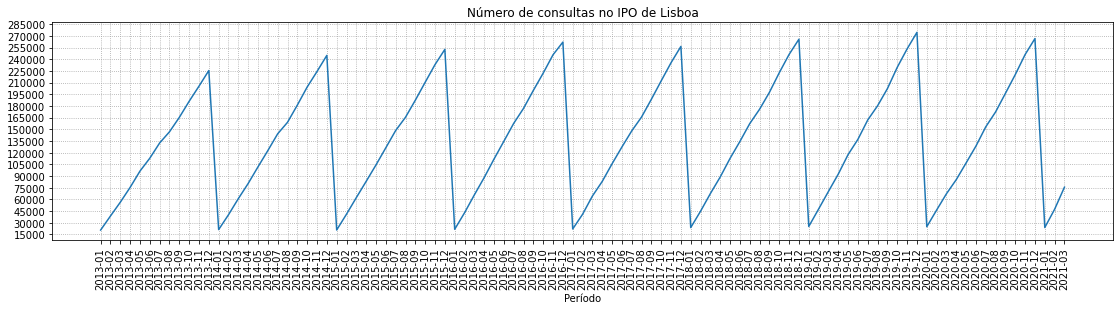

In [5]:
instituição = 'Instituto Português Oncologia de Lisboa, EPE'
df = df_hosp[df_hosp.Instituição==instituição].sort_values('Período').set_index('Período', drop=False)
ax=df['Nº Consultas Médicas Total'].plot(figsize=(19,4));
ax.set_xticks(range(len(df.Período)))
ax.set_xticklabels(df.Período, rotation=90);
ax.set_title('Número de consultas no IPO de Lisboa');
ax.yaxis.set_major_locator(MultipleLocator(15000))
ax.grid(which='major', color='#A0A0A0', linestyle=':')


Analizando o gráfico compreende-se que:

* O número de consultas mensal é cumulativo ao longo de cada ano
* O total de consultas em 2020 no IPO mostra apenas um ligeiro decréscimo face ao ano anterior apesar da pandemia

Vamos ver se o mesmo acontece nas restantes instituições:

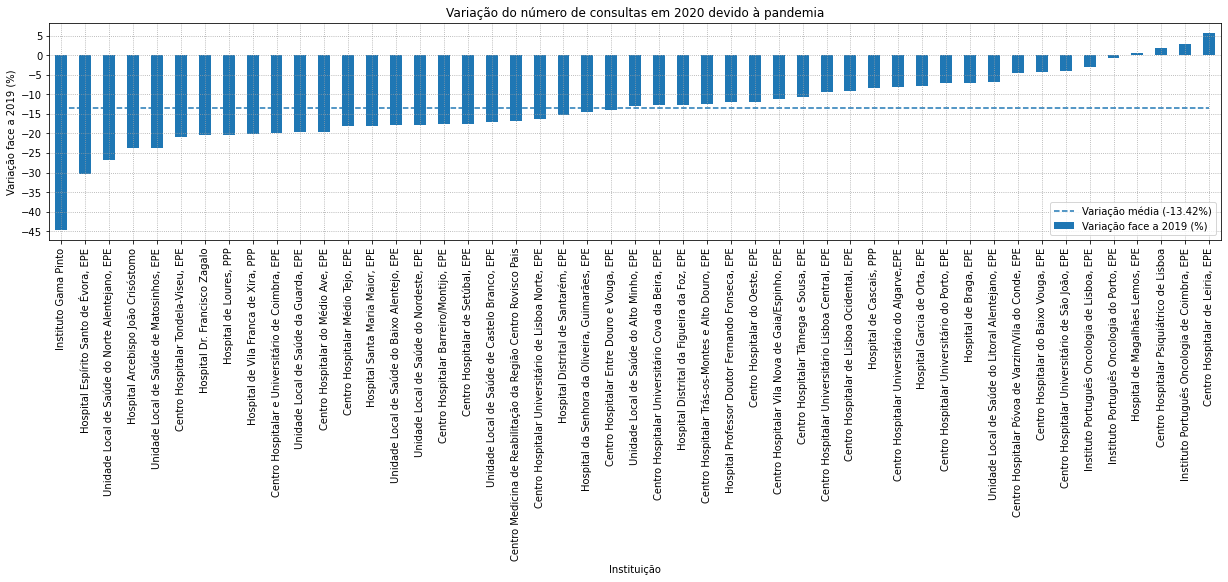

In [6]:
nome = 'Variação face a 2019 (%)'
df = df_hosp.copy()

df = df_hosp[['Período','Nº Consultas Médicas Total','Instituição']].copy().set_index('Instituição')
df = 100*(df[(df.Período=='2020-12')][['Nº Consultas Médicas Total']] - df[df.Período=='2019-12'][['Nº Consultas Médicas Total']])/df[df.Período=='2020-12'][['Nº Consultas Médicas Total']]
df.columns=[nome]

df.sort_values(by=nome, inplace=True)
ax = df.plot(figsize=(21,4), kind='bar')
ax.set_title('Variação do número de consultas em 2020 devido à pandemia');
ax.set_ylabel('Variação face a 2019 (%)');
ax.set_xticks(range(len(df)))
ax.set_xticklabels(df.index, rotation=90);
ax.yaxis.set_major_locator(MultipleLocator(5))
ax.grid(which='major', color='#A0A0A0', linestyle=':')
média =  np.ones(len(df.index))*df[nome].mean()
ax.plot(média, label=f"Variação média ({média[0]:.2f}%)", linestyle='--');
ax.legend(loc='lower right');


Há um decréscimo médio de 13% do número de consultas, embora o impacto seja extremamente variado, desde o Instituto Gama Pinto que fez cerca de metade das consultas que no ano anterior, para CH Leiria que fez mais 5% que no ano anterior.

## 1.4 Evolução mensal do número de consultas

Construir um novo dataframe com as diferenças para o mês anterior, exceto em Janeiro quando devemos manter apenas o valor indicado. Para facilitar vamos focar a atenção nas instituições que têm dados para todos os meses

In [7]:
df_mes = df_hosp.copy()
df_mes['Mês'] = pd.to_datetime(df_mes['Período'] , format='%Y-%m')  
df_mes['Dia'] = pd.to_datetime(df_mes['Periodo_format_2'] , format='%Y/%m/%d')

df_inst_completas = df_mes[['Instituição','Mês']].groupby('Instituição').nunique()
all_inst = len(df_inst_completas)
df_inst_completas=df_inst_completas[df_inst_completas.Mês==df_inst_completas.Mês.max()].index
df_mes = df_mes[df_mes.Instituição.isin(df_inst_completas)]
print(f"Existem {all_inst} instituições das quais vamos usar as {df_mes.Instituição.nunique()} que têm dados para todos os meses.")

Existem 52 instituições das quais vamos usar as 47 que têm dados para todos os meses.


Para estas 47 instituições vamos olhar para as consultas desde 2019 e ver se notamos algum padrão nas consultas mensais.

O código é um pouco complexo, mas a ideia geral é acessível:
* Começamos por criar `pivot_mes` que tem:
  * colunas que são datas, ex: 2019-01-01, 2019-02-01, ... 2019-12-01, 2020-02-01,...
  * linhas são as instituições que têm dados em todos os meses
  * os valores são o número de consultas nessa instituição acumuladas anualmente até esse mês
* Vamos usá-lo para  criar `df_inst` que nos valores contém o número de consultas realizadas nessa instituição apenas nesse mês, para isso:
  * Substuímos cada mês pela diferença entre o valor atual e o valor anterior, efetivamente desfazendo os acumulados
  * Em Janeiro de cada ano repomos o valor que estava originalmente em `pivot_mes` porque os acumulados recomeçam anualmente em Janeiro



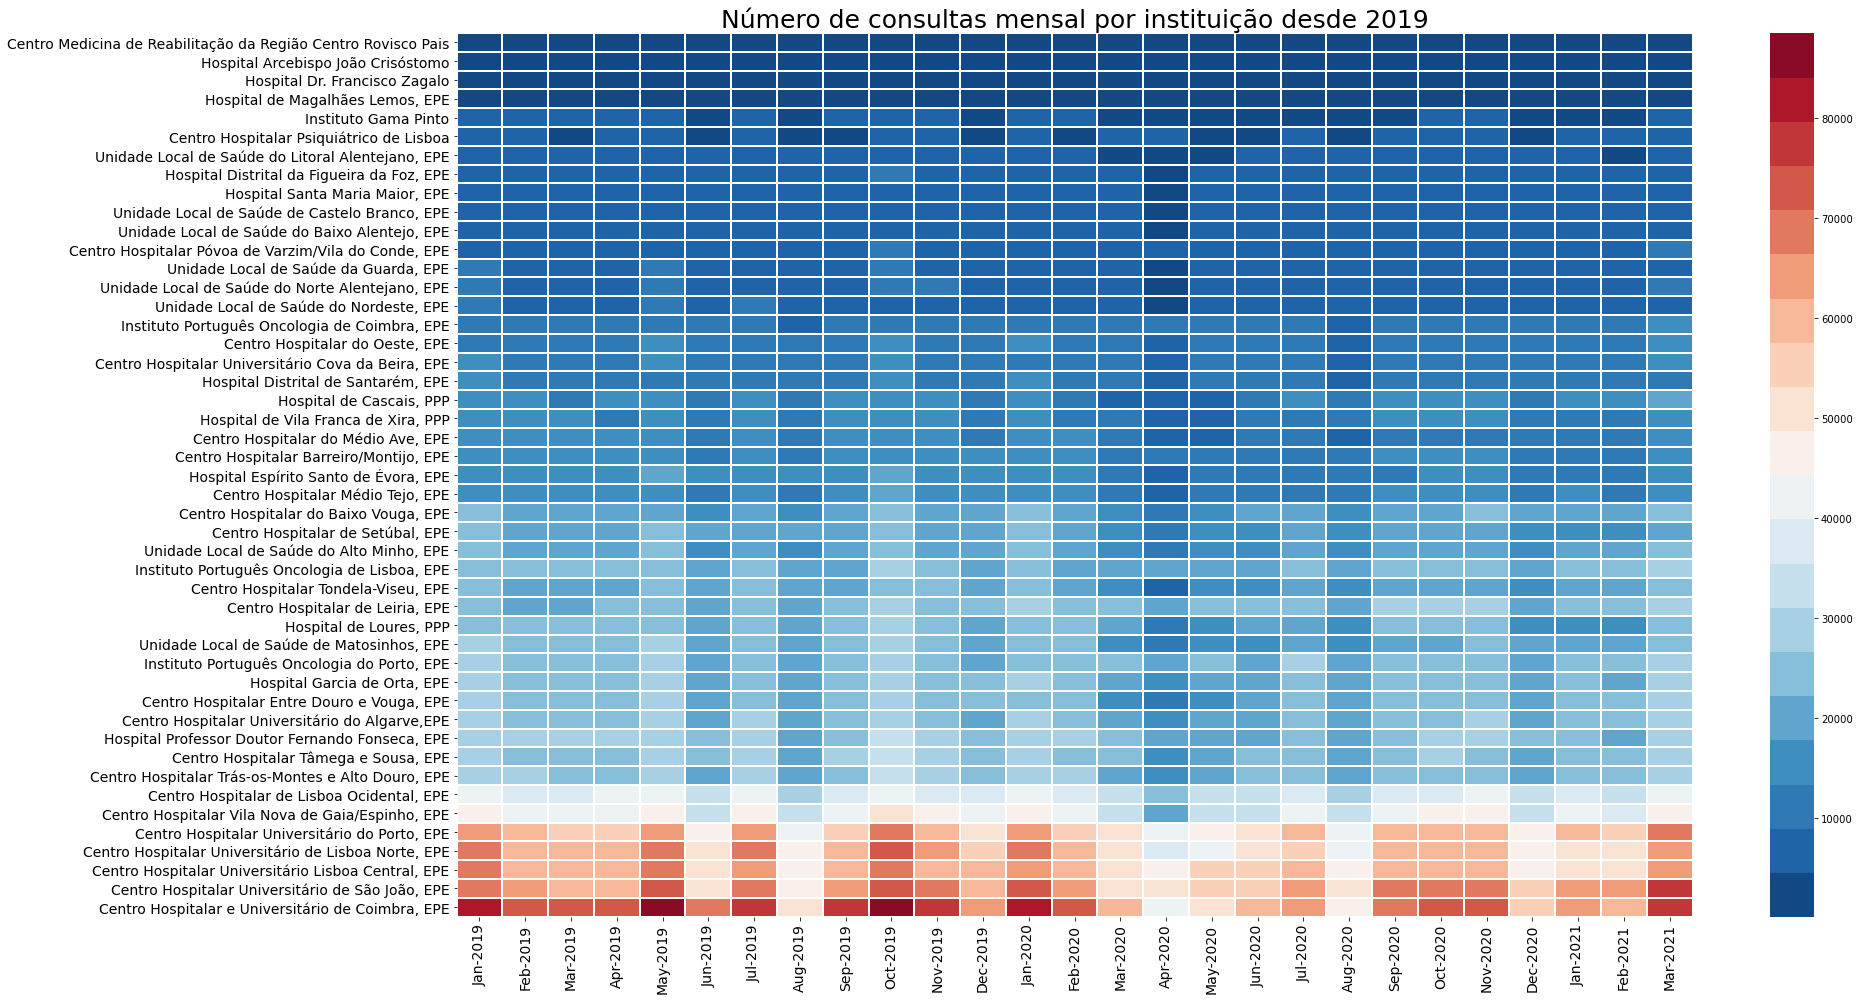

In [9]:
pivot_mes = pd.pivot_table(df_mes, values='Nº Consultas Médicas Total', index=['Instituição'], columns=['Dia'], aggfunc='sum')
df_inst = pivot_mes.T.diff()
df_inst = df_inst.where(df_inst>1).T.iloc[:, 72:]
for i in range(0,len(df_inst.columns),12):
    df_inst.iloc[:,  i] = pivot_mes.iloc[:, 72+i]   # 2019-01-01, 2020-01-01, 2021-01-01, ...
xlabels = get_month_labels_from_date_columns(df_inst)

df_inst.sort_values(by='2019-01-01', inplace=True)
cmap = sns.color_palette('RdBu_r', 20)
fig, ax = plt.subplots(figsize=(28,14))
ax = sns.heatmap(df_inst, square=False, annot=False, cmap = cmap, linewidths=1)
ax.set_yticklabels(df_inst.index,rotation=0, fontsize = 14);
ax.set_xticklabels(xlabels,rotation=90, fontsize = 14);
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_title("Número de consultas mensal por instituição desde 2019", fontsize=25);
plt.tight_layout()

Notam-se: 
* menos consultas em Junho e Agosto, provavelmente efeitos das férias nos feriados de Junho e em Agosto;
* Abril de 2020 foi um mês com poucas consultas especialmente nos grandes hospitais

Vamos ver também comparação dos totais de consultas mensais nos 3 últimos anos: 

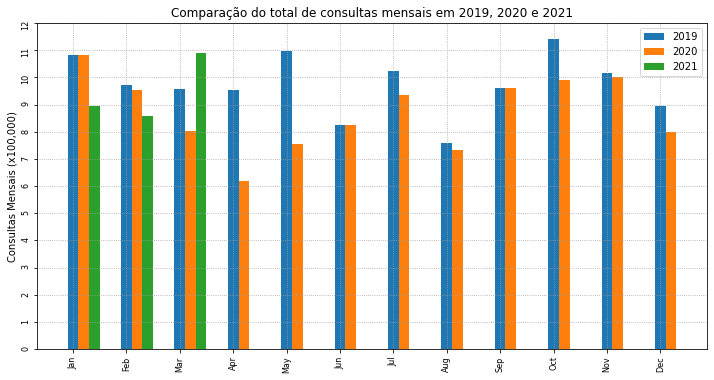

In [11]:
total_mensal = df_inst.sum(axis=0)
total_19 = total_mensal.iloc[:12]
total_20 = total_mensal.iloc[12:24]
total_21 = total_mensal.iloc[24:36]
fig, ax = plt.subplots(figsize=(12,6))
ax.bar(range(0,120,10),total_19.values, width=2, label="2019")
ax.bar(range(2,122,10),total_20.values, width=2, label="2020")
ax.bar(range(4,len(total_21)*10+4,10),total_21.values, width=2, label="2021")
ax.set_xticks(range(0,120,10))
ax.set_xticklabels(month_abbr[1:], rotation=90, fontsize = 8);

step = 100000 
lim = int(step*(2+total_mensal.max()//step))
ticks = list(range(0,lim,step))
ax.set_yticks(ticks)
ax.yaxis.set_major_locator(FixedLocator(ticks))
ax.grid(which='major', color='#A0A0A0', linestyle=':')
ax.set_yticklabels([f"{i//step:,}" for i in ticks], rotation=90, fontsize = 8);
ax.set_ylabel(f'Consultas Mensais (x{step:,})')
ax.legend()
ax.set_title("Comparação do total de consultas mensais em 2019, 2020 e 2021");

In [13]:
covid_start_date = '2020-01-01'
before_covid_days = df_mes.loc[df_mes['Dia']<covid_start_date].index
after_covid_days = df_mes.loc[df_mes['Dia']>=covid_start_date].index

# Obter dados do Covid

In [18]:
df_covid = get_df_from_url('https://covid19-api.vost.pt/Requests/get_full_dataset')
df_covid.fillna(0, inplace=True)
df_covid['data'] = pd.to_datetime(df_covid['data'] , format='%d-%m-%Y')   # data de publicação
df_covid['data_dados'] = pd.to_datetime(df_covid['data_dados'] , format='%d-%m-%Y %H:%M')  # data e hora de recolha
df_covid.rename(columns = {'data':'Dia'}, inplace=True)
df_covid.sort_values(by='Dia', inplace=True)
df_covid.set_index('Dia', inplace=True)
print(f" Dimensão DS : # Dias = {len(df_covid)}, # Colunas = {len(df_covid.columns)}")
df_covid.tail()

 Dimensão DS : # Dias = 455, # Colunas = 92


,data_dados,confirmados,confirmados_arsnorte,confirmados_arscentro,confirmados_arslvt,confirmados_arsalentejo,confirmados_arsalgarve,confirmados_acores,confirmados_madeira,confirmados_estrangeiro,...,obitos_m,confirmados_desconhecidos_m,confirmados_desconhecidos_f,ativos,internados_enfermaria,confirmados_desconhecidos,incidencia_nacional,incidencia_continente,rt_nacional,rt_continente
Dia,,,,,,,,,,,,,,,,,,,,,
2021-05-21,2021-05-21,844288,339013,119447,318984,30019,22102,5153,9570,0.0,...,8938.0,0.0,0.0,22287.0,152.0,351.0,52.6,49.5,1.03,1.03
2021-05-22,2021-05-22,844811,339174,119490,319180,30056,22123,5187,9601,0.0,...,8938.0,0.0,0.0,22328.0,151.0,353.0,52.6,49.5,1.03,1.03
2021-05-23,2021-05-23,845224,339296,119533,319349,30075,22148,5209,9614,0.0,...,8938.0,0.0,0.0,22515.0,162.0,355.0,52.6,49.5,1.03,1.03
2021-05-24,2021-05-24,845465,339356,119553,319446,30083,22161,5235,9631,0.0,...,8939.0,0.0,0.0,22468.0,182.0,357.0,55.6,52.5,1.06,1.06
2021-05-25,2021-05-25,845840,339459,119572,319621,30103,22172,5261,9652,0.0,...,8940.0,0.0,0.0,22171.0,185.0,359.0,55.6,52.5,1.06,1.06
